In [1]:
import torch

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
torch.cuda.is_available()

True

In [4]:
import os

os.chdir('/mnt/f/LiveTalking')
print("working path =", os.getcwd())


working path = /mnt/f/LiveTalking


In [5]:
import wav2lip.face_detection as face_detection

In [6]:
from os import listdir, path
import numpy as np
import scipy, cv2, os, sys, argparse
import json, subprocess, random, string
from tqdm import tqdm
from glob import glob
import torch
import pickle


def video2imgs(vid_path, save_path, ext = '.png',cut_frame = 10000000):
    cap = cv2.VideoCapture(vid_path)
    count = 0
    while True:
        if count > cut_frame:
            break
        ret, frame = cap.read()
        if ret:
            cv2.putText(frame, "LiveTalking", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (128,128,128), 1)
            cv2.imwrite(f"{save_path}/{count:08d}.png", frame)
            count += 1
        else:
            break

def read_imgs(img_list):
    frames = []
    print('reading images...')
    for img_path in tqdm(img_list):
        frame = cv2.imread(img_path)
        frames.append(frame)
    return frames

def get_smoothened_boxes(boxes, T):
	for i in range(len(boxes)):
		if i + T > len(boxes):
			window = boxes[len(boxes) - T:]
		else:
			window = boxes[i : i + T]
		boxes[i] = np.mean(window, axis=0)
	return boxes

def face_detect(images):
	detector = face_detection.FaceAlignment(face_detection.LandmarksType._2D, 
											flip_input=False, device='cuda')

	batch_size = 1
	
	while 1:
		predictions = []
		try:
			for i in tqdm(range(0, len(images), batch_size)):
				predictions.extend(detector.get_detections_for_batch(np.array(images[i:i + batch_size])))
		except RuntimeError:
			if batch_size == 1: 
				raise RuntimeError('Image too big to run face detection on GPU. Please use the --resize_factor argument')
			batch_size //= 2
			print('Recovering from OOM error; New batch size: {}'.format(batch_size))
			continue
		break

	results = []
	pady1, pady2, padx1, padx2 = 0,0,0,0
	for rect, image in zip(predictions, images):
		if rect is None:
			cv2.imwrite('temp/faulty_frame.jpg', image) # check this frame where the face was not detected.
			raise ValueError('Face not detected! Ensure the video contains a face in all the frames.')

		y1 = max(0, rect[1] - pady1)
		y2 = min(image.shape[0], rect[3] + pady2)
		x1 = max(0, rect[0] - padx1)
		x2 = min(image.shape[1], rect[2] + padx2)
		
		results.append([x1, y1, x2, y2])

	boxes = np.array(results)
	boxes = get_smoothened_boxes(boxes, T=5)
	results = [[image[y1: y2, x1:x2], (y1, y2, x1, x2)] for image, (x1, y1, x2, y2) in zip(images, boxes)]

	del detector
	return results 

# if __name__ == "__main__":
#     avatar_path = f"./results/avatars/{args.avatar_id}"
#     full_imgs_path = f"{avatar_path}/full_imgs" 
#     face_imgs_path = f"{avatar_path}/face_imgs" 
#     coords_path = f"{avatar_path}/coords.pkl"
#     osmakedirs([avatar_path,full_imgs_path,face_imgs_path])
#     print(args)

#     #if os.path.isfile(args.video_path):
#     video2imgs(args.video_path, full_imgs_path, ext = 'png')
#     input_img_list = sorted(glob(os.path.join(full_imgs_path, '*.[jpJP][pnPN]*[gG]')))

#     frames = read_imgs(input_img_list)
#     face_det_results = face_detect(frames) 
#     coord_list = []
#     idx = 0
#     for frame,coords in face_det_results:        
#         #x1, y1, x2, y2 = bbox
#         resized_crop_frame = cv2.resize(frame,(args.img_size, args.img_size)) #,interpolation = cv2.INTER_LANCZOS4)
#         cv2.imwrite(f"{face_imgs_path}/{idx:08d}.png", resized_crop_frame)
#         coord_list.append(coords)
#         idx = idx + 1
	
#     with open(coords_path, 'wb') as f:
#         pickle.dump(coord_list, f)

In [7]:
frames = read_imgs(["./data/avatars/wav2lip384_avatar2/full_imgs/00000000.png"])

reading images...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.07it/s]


In [8]:
print(frames[0].shape)

(1038, 1920, 3)


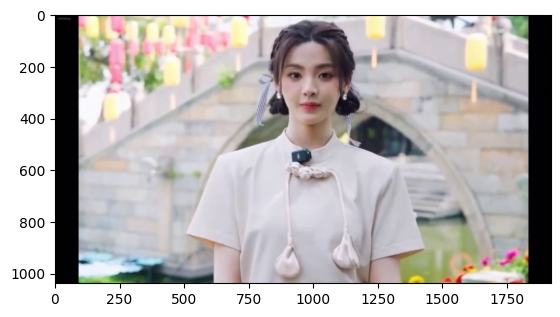

In [9]:
import matplotlib.pyplot as plt 

c = plt.imshow(frames[0][:,:,[2,1,0]]) 

In [10]:
results = face_detect(frames)

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.38s/it]


In [11]:
img, coord = results[0]

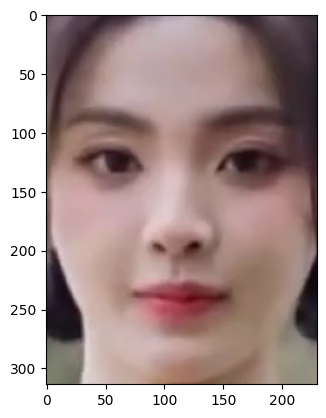

In [12]:
c = plt.imshow(img[:,:,[2,1,0]]) 

In [13]:
print(coord)

(np.int64(112), np.int64(426), np.int64(872), np.int64(1102))


In [14]:
from musetalk.utils.face_parsing import FaceParsing

In [15]:
fp = FaceParsing(os.path.abspath('./models/face-parse-bisent/resnet18-5c106cde.pth'),
                 os.path.abspath('./models/face-parse-bisent/79999_iter.pth'))

In [16]:
def face_seg(image):
    seg_image = fp(image)
    if seg_image is None:
        print("error, no person_segment")
        return None

    seg_image = seg_image.resize(image.size)
    return seg_image

In [17]:
print(img.shape)

(314, 230, 3)


In [18]:
img_reshuffled = img[:,:,[2,1,0]]
print(img_reshuffled.shape)

(314, 230, 3)


In [19]:
from PIL import Image
body = Image.fromarray(img[:, :, ::-1])

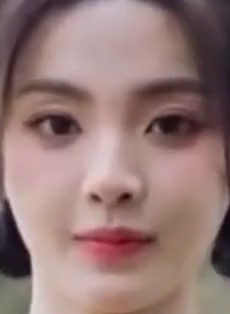

In [20]:
body

In [42]:
mask_image = face_seg(body)

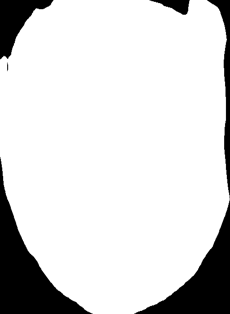

In [43]:
mask_image

In [44]:
mask_image=np.array(mask_image)
mask_image[:mask_image.shape[0]//3*2:,:]=0

In [45]:
mask_image

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

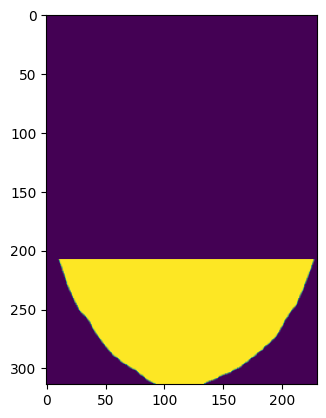

In [46]:
c = plt.imshow(mask_image) 

In [50]:
blurred = cv2.GaussianBlur(np.array(mask_image), (15, 15), 0)

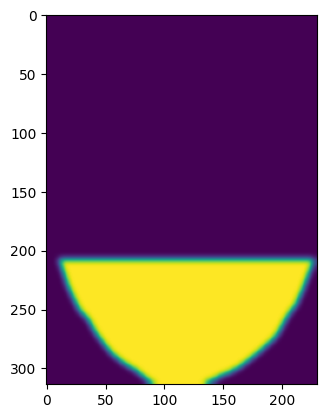

In [51]:
c = plt.imshow(blurred) 